In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import time
%matplotlib inline

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

#import tensorflow as tf

In [2]:
train = pd.read_csv('Data/train.csv', index_col=0)
test = pd.read_csv('Data/test.csv', index_col=0)
survived = train.Survived

In [3]:
print(train.shape)
print(test.shape)
print(survived.shape)

(891, 11)
(418, 10)
(891,)


In [4]:
data = pd.concat([train.drop(['Survived'], axis=1), test])

In [5]:
print(data.shape)

(1309, 10)


In [6]:
data.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


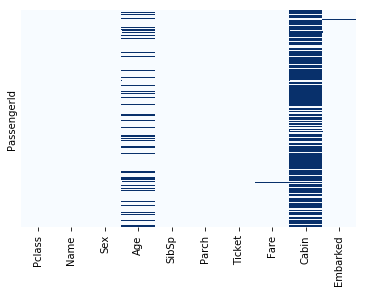

In [7]:
#Survived, Pclass, Name, Sex, SibSp, Parch, Ticket, Fare - all have values
#Plot heat map of what is missing
sns.heatmap(data.isna(), yticklabels=False, cbar=False, cmap='Blues')

In [8]:
data[data.Fare.isna()]

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
1044,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S


In [9]:
data[data.Embarked.isna()]

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
62,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
830,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


In [10]:
#2 passengers do not have an Embarked location.  They are first class and a cabin that starts with B, all of whom
# embarked from either C or S.  Givent that S is far more common of the two, I am assigning to S
data.Embarked.fillna('S', inplace=True)

#There is 1 passenger with no fare.  Since there seems to be no other person on the ticket or with the same name,
#I am assigning that passenger the median 3rd class fare
data.Fare.fillna(data[data.Pclass == 3]['Fare'].median(), inplace=True)

#Extract the person's title to a new column
data['Title'] = data['Name'].apply(lambda x: re.compile(r'[a-zA-Z]+\.').findall(x)[0])
titles  = set(data['Title'])

#Replace unknown cabins with U
data.Cabin.fillna('U', inplace=True)

#Extract the deck letter
data['Deck'] = data['Cabin'].apply(lambda x: re.compile(r'[A-Z]+').findall(x)[0])

#add a column whether the person is under 16
data['Child'] = data.Age < 16
data['Child'] = data['Child'].astype(int)

#family size
data['FamSize'] = data.SibSp + data.Parch + 1

#convert the Pclass column to object
data['Pclass'] = data.Pclass.astype(str)

In [11]:
#fill in the missing ages with the median based on Pclass and Title
median_ages = data.groupby(['Pclass','Title'])['Age'].median()
median_ages['3','Ms.'] = 18  #fill in a missing category

def fill_na_ages(row):
    if pd.isna(row['Age']):
        return median_ages[row['Pclass'], row['Title']]
    else:
        return row['Age']
    
data['Age'] = data.apply(fill_na_ages, axis=1)

In [12]:
#many of the Cabin values are U - fill in some of those based on the Deck of other people on the same ticket
#find the highest Deck letter (min) of each ticket
deck_mins = data.groupby(['Ticket'])['Deck'].min()

#function to fill in deck
def fill_in_deck(row):
    if row.Deck == 'U':
        return deck_mins[row.Ticket]
    else:
        return row.Deck
    
data.Deck = data.apply(fill_in_deck, axis=1)

In [13]:
#only improved the Deck value a little bit
data.groupby(['Deck'])['Name'].count()

Deck
A     22
B     68
C    104
D     46
E     42
F     23
G      5
T      1
U    998
Name: Name, dtype: int64

In [14]:
def per_person_fare(row):
    if row.SibSp > 0:
        return row.Fare / (row.SibSp + row.Parch)
    elif row.Parch > 0:
        return row.Fare / (row.SibSp + row.Parch)
    else:
        return row.Fare

data['pp_fare'] = data.apply(per_person_fare, axis=1)

In [15]:
data = pd.get_dummies(data.drop(['Name','Ticket','Cabin'],axis=1))

In [16]:
data.head()

,Age,SibSp,Parch,Fare,Child,FamSize,pp_fare,Pclass_1,Pclass_2,Pclass_3,...,Title_Sir.,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Deck_U
PassengerId,,,,,,,,,,,,,,,,,,,,,
1,22.0,1,0,7.2500,0,2,7.2500,0,0,1,...,0,0,0,0,0,0,0,0,0,1
2,38.0,1,0,71.2833,0,2,71.2833,1,0,0,...,0,0,0,1,0,0,0,0,0,0
3,26.0,0,0,7.9250,0,1,7.9250,0,0,1,...,0,0,0,0,0,0,0,0,0,1
4,35.0,1,0,53.1000,0,2,53.1000,1,0,0,...,0,0,0,1,0,0,0,0,0,0
5,35.0,0,0,8.0500,0,1,8.0500,0,0,1,...,0,0,0,0,0,0,0,0,0,1


In [17]:
data.columns

Index(['Age', 'SibSp', 'Parch', 'Fare', 'Child', 'FamSize', 'pp_fare',
       'Pclass_1', 'Pclass_2', 'Pclass_3', 'Sex_female', 'Sex_male',
       'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Title_Capt.', 'Title_Col.',
       'Title_Countess.', 'Title_Don.', 'Title_Dona.', 'Title_Dr.',
       'Title_Jonkheer.', 'Title_Lady.', 'Title_Major.', 'Title_Master.',
       'Title_Miss.', 'Title_Mlle.', 'Title_Mme.', 'Title_Mr.', 'Title_Mrs.',
       'Title_Ms.', 'Title_Rev.', 'Title_Sir.', 'Deck_A', 'Deck_B', 'Deck_C',
       'Deck_D', 'Deck_E', 'Deck_F', 'Deck_G', 'Deck_T', 'Deck_U'],
      dtype='object')

In [18]:
traindf = data.iloc[:len(train)]
testdf = data.iloc[len(train):]

### Logistic Regression

In [19]:
xtrain = traindf
ytrain = survived
xtest = testdf

In [48]:
lm1 = LogisticRegression(penalty='l1', verbose=3)
lm2 = LogisticRegression(penalty='l2', verbose=3)

In [49]:
lm1.fit(xtrain, ytrain)
lm2.fit(xtrain, ytrain)

[LibLinear][LibLinear]

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=3, warm_start=False)

In [51]:
pd.DataFrame(list(zip(xtrain.columns, np.transpose(lm1.coef_), np.transpose(lm2.coef_))), 
             columns=['Attribute','Coeff. LM1','Coeff. LM2'])

,Attribute,Coeff. LM1,Coeff. LM2
0,Age,[-0.028382492822751567],[-0.03066764948717632]
1,SibSp,[-0.41337301771369517],[-0.49452222723496103]
2,Parch,[-0.235202483730507],[-0.32428271446445356]
3,Fare,[0.004364883345619096],[0.0052470156524990555]
4,Child,[0.1108946280222658],[0.3549965410709914]
5,FamSize,[-0.10143682017496557],[-0.030660738348615706]
6,pp_fare,[3.789849033576425e-05],[-0.000604119912999792]
7,Pclass_1,[0.8577219669747866],[1.0058398384940601]
8,Pclass_2,[0.10018043783733303],[0.39022320157150364]
9,Pclass_3,[-0.8765786797258384],[-0.6079188367148589]


In [41]:
lm1_predict = pd.concat([pd.DataFrame(test.index),
                         pd.DataFrame(lm1.predict(xtest), columns=['Survived'])], axis=1)
lm2_predict = pd.concat([pd.DataFrame(test.index), 
                         pd.DataFrame(lm2.predict(xtest), columns=['Survived'])], axis=1)

In [42]:
lm1_predict.to_csv('Data/lm1.csv', index=False)
lm2_predict.to_csv('Data/lm2.csv', index=False)

In [54]:
lm1.score

<bound method ClassifierMixin.score of LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=3, warm_start=False)>

In [58]:
print('LM1 accuracy', metrics.accuracy_score(ytrain, lm1.predict(xtrain)))
print('LM1 precision', metrics.precision_score(ytrain, lm1.predict(xtrain)))

LM1 accuracy 0.8383838383838383
LM1 precision 0.8074534161490683


In [59]:
print('LM2 accuracy', metrics.accuracy_score(ytrain, lm2.predict(xtrain)))
print('LM2 precision', metrics.precision_score(ytrain, lm2.predict(xtrain)))

LM2 accuracy 0.8417508417508418
LM2 precision 0.8092307692307692


LM1 scored 0.78947 and LM2 scored 0.78468

In [68]:
cvmethod = KFold(n_splits=5)
parameters = {'penalty':['l1','l2'], \
             'C':[0.1,0.5,1.0,5,10,100], \
             'fit_intercept':[True,False]}
nmodels = np.product([len(par) for par in parameters.values()])

start = time.time()
cvmodel = GridSearchCV(LogisticRegression(), parameters, cv=cvmethod, scoring='accuracy', \
                      verbose=1, n_jobs=4)
cvmodel.fit(xtrain,ytrain)
stop = time.time()
print(cvmodel.best_score_, cvmodel.best_params_)
print('Avg time per model (s) ', (stop-start)/float(nmodels*4))

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   22.6s


0.8237934904601572 {'C': 1.0, 'fit_intercept': True, 'penalty': 'l1'}
Avg time per model (s)  0.25024377306302387


[Parallel(n_jobs=4)]: Done 120 out of 120 | elapsed:   23.6s finished


The Grid Search CV found that the best parameters were the L1 penalty (Lasso) with the default C and fit_intercept.  There doesn't appear to be a way to improve the accuracy by tweaking the logistic regression model

### Random Forest

In [20]:
rfc_params = {'n_estimators':[1,10,50,100,500], 'max_depth':[None,10,25,50], \
             'max_features':['auto','log2',None], 'oob_score':[False,True]}

rfc_model = GridSearchCV(RandomForestClassifier(), rfc_params, scoring='accuracy', \
                        cv=KFold(n_splits=3), verbose=1, n_jobs=4)
rfc_model.fit(xtrain,ytrain)
print(rfc_model.best_score_, rfc_model.best_params_)

Fitting 3 folds for each of 120 candidates, totalling 360 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   23.8s
[Parallel(n_jobs=4)]: Done 331 tasks      | elapsed:   44.0s
[Parallel(n_jobs=4)]: Done 353 out of 360 | elapsed:   45.3s remaining:    0.8s
[Parallel(n_jobs=4)]: Done 360 out of 360 | elapsed:   47.8s finished


0.8338945005611672 {'max_depth': 10, 'max_features': 'log2', 'n_estimators': 500, 'oob_score': True}


In [78]:
rfc = RandomForestClassifier(max_depth=10, n_estimators=50)
rfc.fit(xtrain,ytrain)

rfc_pred1 = pd.concat([pd.DataFrame(test.index), pd.DataFrame(rfc.predict(xtest), columns=['Survived'])], axis=1)

Only scored a 0.7799.  Not an improvement of the LM1 model

In [76]:
#change the estimators to 500
rfc = RandomForestClassifier(max_depth=10, n_estimators=500)
rfc.fit(xtrain,ytrain)

rfc_pred2 = pd.concat([pd.DataFrame(test.index), pd.DataFrame(rfc.predict(xtest), columns=['Survived'])], axis=1)

In [79]:
rfc_pred1.to_csv('Data/rfc1.csv', index=False)
rfc_pred2.to_csv('Data/rfc2.csv', index=False)

The larger predictors scored a 0.78468

### KNeighbors Classifier

In [84]:
knn_params = {'n_neighbors':[2,3,4,5,10], 'weights':['uniform','distance'], \
             'algorithm':['auto','ball_tree','kd_tree','brute']}

knn_model = GridSearchCV(KNeighborsClassifier(), knn_params, scoring='accuracy', \
                        verbose=1)
knn_model.fit(xtrain,ytrain)
print(knn_model.best_score_, knn_model.best_params_)

Fitting 3 folds for each of 40 candidates, totalling 120 fits
0.734006734006734 {'algorithm': 'auto', 'n_neighbors': 5, 'weights': 'uniform'}


[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    2.2s finished


In [86]:
#the best parameters were all default
knn = KNeighborsClassifier()

knn.fit(xtrain,ytrain)

knn_pred = pd.concat([pd.DataFrame(test.index), pd.DataFrame(knn.predict(xtest), columns=['Survived'])], axis=1)

In [87]:
knn_pred.to_csv('Data/knn.csv', index=False)

Only scored 0.62679, which is far worse than prior models

### Support Vector Machines

In [22]:
cvmethod = StratifiedKFold(n_splits=4, shuffle=True)

In [20]:
scaler = StandardScaler()

scaled_data = scaler.fit_transform(data.values)
scaled_data = pd.DataFrame(scaled_data, index=data.index, columns=data.columns)

In [24]:
sc_xtrain = scaled_data.iloc[:len(train)]
sc_xtest = scaled_data.iloc[len(train):]

In [ ]:
svm_params = {'kernel':['rbf','poly'], \
              'gamma':[0.01, 0.1, 0.5], 'C':[1,10,100]}

svm_model = GridSearchCV(SVC(), svm_params, cv = cvmethod, scoring = 'accuracy', \
                     verbose = 1, n_jobs = 4)

svm_model.fit(sc_xtrain,ytrain)
print(svm_model.best_score_, svm_model.best_params_)

Fitting 4 folds for each of 18 candidates, totalling 72 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   37.0s


### Gradient Boosting

In [23]:
gb_params = {'max_depth':[3,5,8], 'learning_rate': [0.1, 0.3, 0.5], 'subsample': [0.8, 1.0]}

gb_model = GridSearchCV(GradientBoostingClassifier(), gb_params, cv= cvmethod, \
                       scoring = 'accuracy', verbose=1, n_jobs=4)

gb_model.fit(xtrain,ytrain)
print(gb_model.best_score_, gb_model.best_params_)

Fitting 4 folds for each of 18 candidates, totalling 72 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   25.5s
[Parallel(n_jobs=4)]: Done  72 out of  72 | elapsed:   27.7s finished


0.8282828282828283 {'learning_rate': 0.1, 'max_depth': 3, 'subsample': 1.0}


In [25]:
gb = GradientBoostingClassifier(max_depth=3, learning_rate=0.1, subsample=1.0)

gb.fit(xtrain,ytrain)

gb_pred = pd.concat([pd.DataFrame(test.index), pd.DataFrame(gb.predict(xtest), columns=['Survived'])],axis=1)

In [26]:
gb_pred.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [27]:
gb_pred.to_csv('Data/grad_boost.csv', index=False)

This scored a 0.76555, which is not an improvement of my best score